#데이콘 집 Basic 값 예측 경진대회
##### 처음에는 RandomForest, Gradient Boost, XGBoost, LigthGBM, CatBoost의 모델들을 Optuna를 통해 하이퍼 파라미터를 찾아 교차 검증해 보고, Stacking ensemble도 해보았지만 대부분의 모델이 Overfitting이 발생했습니다.
> 실험 해본 모델 중 **Catboost**가 점수가 높아, 간단한 파라미터 조정 후 OOF 앙상블 진행  
> **Public: 0.095 (44등), Private: 0.0995점 (7등)**
##### 좋은 기법으로 모델을 구현하는 것도 중요하지만 다른 분들의 코드를 보니 EDA를 통해 데이터의 특징과 의미를 얻는 것이 제일 중요하다고 느끼게 되었습니다.
##### 또한 Public과 Private의 등수 차이가 많이 커서 어떠한 이유로 발생했는지 생각 해 보는 시간이 필요할 거 같습니다.


In [ ]:
!pip install catboost

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

def NMAE(true, pred):
    mae = np.mean(np.abs(true-pred))
    score = mae / np.mean(np.abs(true))
    return score

train = pd.read_csv('/content/drive/MyDrive/data/dacon/basic/train.csv')
test = pd.read_csv('/content/drive/MyDrive/data/dacon/basic/test.csv')

##Feature
>id: 데이터 고유<br>
OverallQual: 전반적 재료, 마감 품질<br>
YearBuilt: 완공 연도<br>
YearRemodAdd: 리모델링 연도<br>
ExterQual: 외관 재료 품질<br>
BsmtQual: 지하실 높이<br>
TotalBsmtSF: 지하실 면적<br>
1stFlrSF: 1층 면적<br>
GrLivArea: 지상층 생활 면적<br>
FullBath: 지상층 화장실 개수<br>
KitchenQual: 부억 품질<br>
GarageYrBlt: 차고 완공 연도<br>
GarageCars: 차고 자리 개수<br>
GarageArea: 차고 면적<br>
target: 집값(달러 단위)<br>

In [ ]:
train.head()

,id,Overall Qual,Gr Liv Area,Exter Qual,Garage Cars,Garage Area,Kitchen Qual,Total Bsmt SF,1st Flr SF,Bsmt Qual,Full Bath,Year Built,Year Remod/Add,Garage Yr Blt,target
0,1,10,2392,Ex,3,968,Ex,2392,2392,Ex,2,2003,2003,2003,386250
1,2,7,1352,Gd,2,466,Gd,1352,1352,Ex,2,2006,2007,2006,194000
2,3,5,900,TA,1,288,TA,864,900,TA,1,1967,1967,1967,123000
3,4,5,1174,TA,2,576,Gd,680,680,TA,1,1900,2006,2000,135000
4,5,7,1958,Gd,3,936,Gd,1026,1026,Gd,2,2005,2005,2005,250000


결측치 확인

In [ ]:
train.isnull().sum()

id                0
Overall Qual      0
Gr Liv Area       0
Exter Qual        0
Garage Cars       0
Garage Area       0
Kitchen Qual      0
Total Bsmt SF     0
1st Flr SF        0
Bsmt Qual         0
Full Bath         0
Year Built        0
Year Remod/Add    0
Garage Yr Blt     0
target            0
dtype: int64

In [ ]:
test.isnull().sum()

id                0
Overall Qual      0
Gr Liv Area       0
Exter Qual        0
Garage Cars       0
Garage Area       0
Kitchen Qual      0
Total Bsmt SF     0
1st Flr SF        0
Bsmt Qual         0
Full Bath         0
Year Built        0
Year Remod/Add    0
Garage Yr Blt     0
dtype: int64

#데이터 전처리
> Garage Yr Blt(차고 완공 연도)에 오타로 추정 되는 이상치를 발견하여 값을 변경하였다.

In [ ]:
train.describe()

,id,Overall Qual,Gr Liv Area,Garage Cars,Garage Area,Total Bsmt SF,1st Flr SF,Full Bath,Year Built,Year Remod/Add,Garage Yr Blt,target
count,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000
mean,675.500000,6.208889,1513.542222,1.870370,502.014815,1082.644444,1167.474074,1.560741,1972.987407,1985.099259,1978.471852,186406.312593
std,389.855743,1.338015,487.523239,0.652483,191.389956,384.067713,375.061407,0.551646,29.307257,20.153244,25.377278,78435.424758
min,1.000000,2.000000,480.000000,1.000000,100.000000,105.000000,480.000000,0.000000,1880.000000,1950.000000,1900.000000,12789.000000
25%,338.250000,5.000000,1144.000000,1.000000,368.000000,816.000000,886.250000,1.000000,1955.000000,1968.000000,1961.000000,135000.000000
50%,675.500000,6.000000,1445.500000,2.000000,484.000000,1009.000000,1092.500000,2.000000,1976.000000,1993.000000,1978.500000,165375.000000
75%,1012.750000,7.000000,1774.500000,2.000000,588.000000,1309.500000,1396.500000,2.000000,2002.000000,2004.000000,2002.000000,217875.000000
max,1350.000000,10.000000,4476.000000,5.000000,1488.000000,2660.000000,2898.000000,4.000000,2010.000000,2010.000000,2207.000000,745000.000000


In [ ]:
train[train['Garage Yr Blt'] > 2020]

,id,Overall Qual,Gr Liv Area,Exter Qual,Garage Cars,Garage Area,Kitchen Qual,Total Bsmt SF,1st Flr SF,Bsmt Qual,Full Bath,Year Built,Year Remod/Add,Garage Yr Blt,target
254,255,8,1564,Gd,2,502,Ex,1546,1564,Gd,2,2006,2007,2207,267300


In [ ]:
train.at[254, 'Garage Yr Blt'] = 2007

필요없는 id변수 버리기
> LabelEncoder로 범주형 변수 -> 숫자형 변수 변경

In [ ]:
train.drop(['id'], axis = 1, inplace = True)
test.drop(['id'], axis = 1, inplace = True)

cate = ['Exter Qual', 'Kitchen Qual', 'Bsmt Qual']
encoder = LabelEncoder()
train[cate] = train[cate].apply(encoder.fit_transform)
test[cate] = test[cate].apply(encoder.fit_transform)

상관관계 확인
> target과 Overall Qual가 가장 높은 상관관계를 가지고 있다.

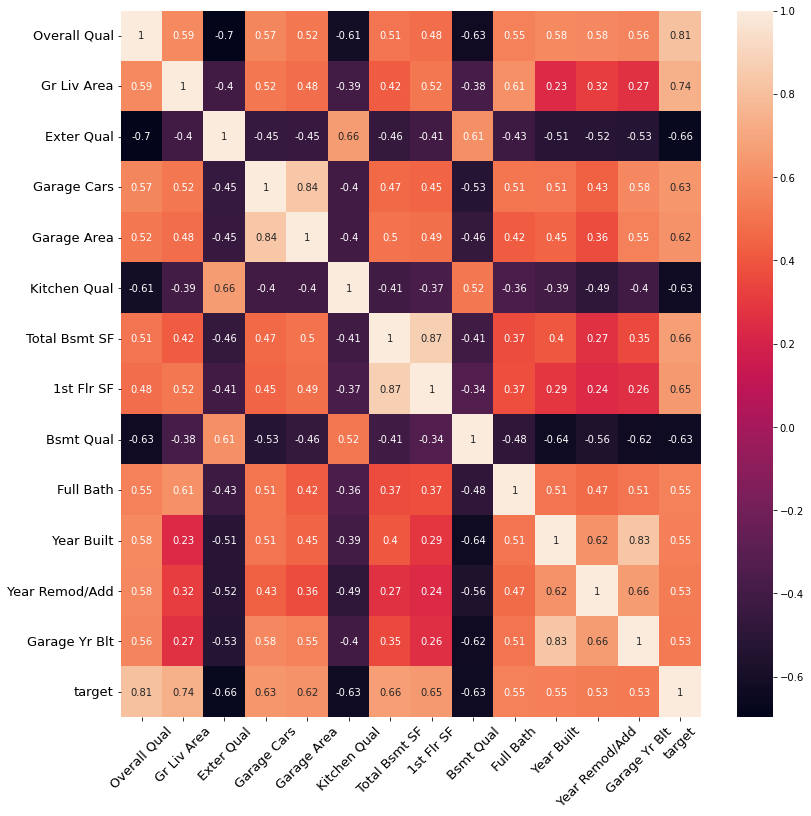

In [ ]:
plt.figure(figsize = (13, 13))
sns.heatmap(train.corr(), annot = True)
plt.xticks(rotation = 45, size = 13)
plt.yticks(size = 13)
plt.show()

In [ ]:
x = train.drop(['target'], axis = 1)
y = train['target']

# array 형태로 변환
x = np.array(x)
y = np.array(y)
test = np.array(test)

#CatBoostRegressor + OOF 
>OOF 기법은 교차 검증으로 나온 각 모델의<br>
동일한 test데이터에 대해 예측 값을 평균 계산하는 방식이다.




In [ ]:
from catboost import CatBoostRegressor
from sklearn.model_selection import KFold

kfold = KFold(n_splits = 10, shuffle = True, random_state = 1234)

n_iter = 0
cv_nmae= []

cat_oof = np.zeros(test.shape[0]) # 예측 값을 계산하기 위해 초깃 값을 모두 0으로 설정

for train_index, val_index in kfold.split(x, y):
    x_train, x_val = x[train_index], x[val_index]
    y_train, y_val = y[train_index], y[val_index]

    cat_reg =  CatBoostRegressor(n_estimators = 2000,
                                 learning_rate = 0.01,
                                 random_state = 1234)

    cat_reg.fit(x_train, y_train, verbose = 0)
    pred_cat = cat_reg.predict(x_val)

    n_iter += 1
    nmae = NMAE(y_val, pred_cat)

    print('#{0} 교차 검증:{1}'.format(n_iter, nmae))
    cv_nmae.append(nmae)
    cat_oof += cat_reg.predict(test)/10  # 교차 검증 된 모델로 예측 값들의 평균 계산

print('## 평균 검증:', np.mean(cv_nmae)) 

#1 교차 검증:0.08939885058272606
#2 교차 검증:0.08432761939061333
#3 교차 검증:0.0855772546821033
#4 교차 검증:0.09415479424142963
#5 교차 검증:0.09009069259974371
#6 교차 검증:0.09939307697534379
#7 교차 검증:0.10689027161254923
#8 교차 검증:0.09271696250496278
#9 교차 검증:0.09638475327080857


submission 제출

In [ ]:
submission = pd.read_csv('/content/drive/MyDrive/data/dacon/basic/sample_submission.csv')
submission = pd.DataFrame({'id':submission['id'], 'target':cat_oof})
submission.to_csv('submission.csv', index = False)

In [ ]:
submission